# End to end Dog Breed multi-classification

This notebook builds an end to end multi class image classifier using TensorFlow 2.50 and TensorFlow Hub.

## 1. Problem definition

Identifying a dog breed given an image of a dog.

When I am sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we are using is from Kaggle's dog breed identification competition, available in the link below.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

For each image in the test set, we must predict a probability for each of the different breeds.
Find more on evaluation in the link:

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Informations about the data:
* We are dealing with images(unstructured data), so it is best to use deep learning & transfer learning.
* There are 120 breed of dog, this means there are 120 different classes.
* There are arround 10,000+ images in the training set(these images have labels).
* There are arround 10,000+ images in the test set(these images does not have labels because we will want to predict them).


## Import needed libraries & packages

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [63]:
# Unzip the uploaded data into Google Drive
#!unzip "drive/MyDrive/Dogbreed_Identification/dog-breed-identification.zip" -d "drive/MyDrive/Dogbreed_Identification/"

## Get our Workspace ready

* Import TensorFlow 2.x.
* Import TensorFlow Hub.
* Make sure we are using GPU.

In [64]:
# Import TensorFlow into colab
import tensorflow as tf
import tensorflow_hub as hub

print('TensorFlow_Version =', tf.__version__)
print('TF Hub_Version =', hub.__version__)

# Check for the GPU availability
print('GPU', 'Available YESS!!!' if tf.config.list_physical_devices('GPU') else 'not available :(')

TensorFlow_Version = 2.17.0
TF Hub_Version = 0.16.1
GPU Available YESS!!!


## Getting our data ready
With all Machine learning models our data must be in  numerical format. So that's what we will be doing first, turning our images into tensors(numerical representation).

Let's start by accessing our data and checking out the labels.

In [65]:
labels_csv = pd.read_csv('drive/MyDrive/Dogbreed_Identification/labels.csv')
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


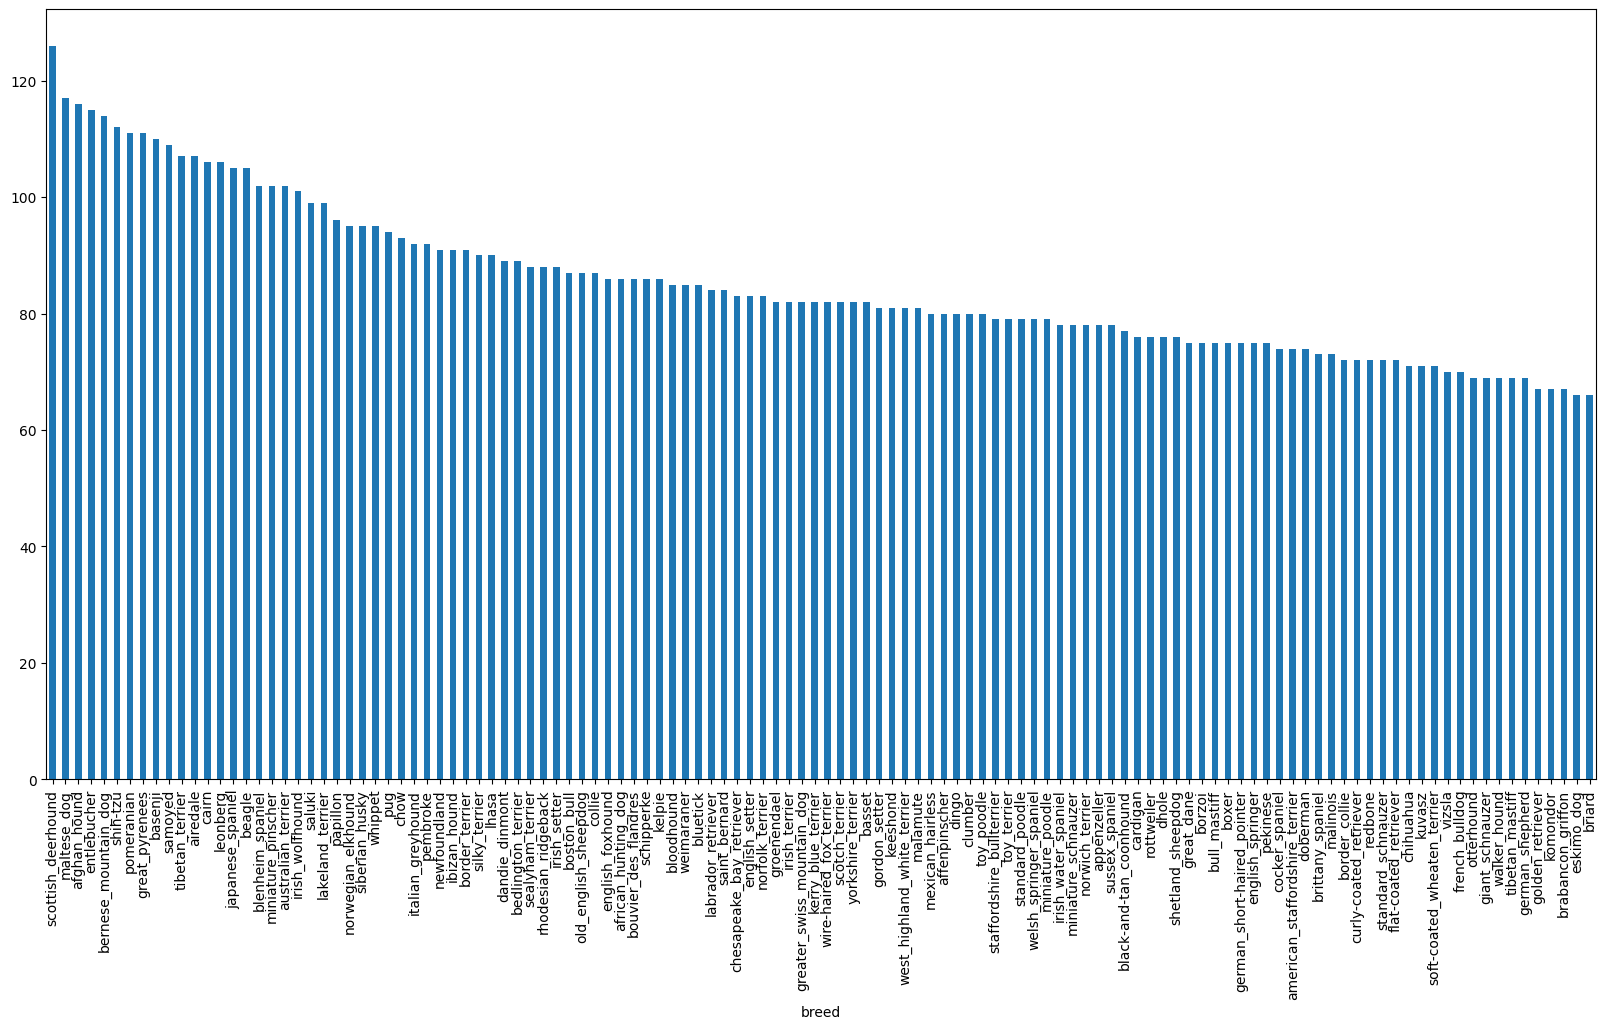

In [66]:
# Plot all breed available in our labels
labels_csv.breed.value_counts().plot.bar(figsize=(20, 10));

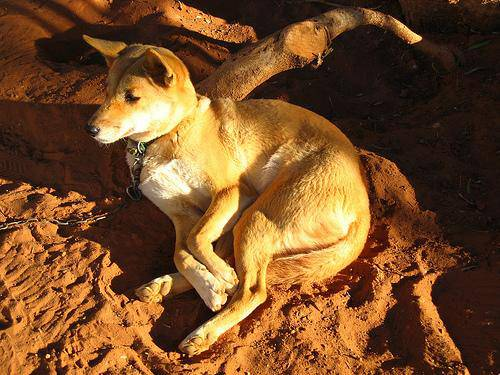

In [67]:
# Let's view an image
from IPython.display import Image
Image('drive/MyDrive/Dogbreed_Identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

## Getting Images and their labels

* Let's get a list of all our images pathnames.

In [68]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [69]:
# Create pathnames from Image ID's
filenames = ['drive/MyDrive/Dogbreed_Identification/train/' + filename + '.jpg' for filename in labels_csv['id']]
filenames[:10]

['drive/MyDrive/Dogbreed_Identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dogbreed_Identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [70]:
# Check whether number of filenames match the number of actual images files
import os
if len(os.listdir('drive/MyDrive/Dogbreed_Identification/train/')) == len(filenames):
  print('Filenames match actual amount of files, Proceed!')
else:
  print('Filenames does not match actual amount of file, check the target directory')

Filenames match actual amount of files, Proceed!


Since we have now got our training images filepaths in a list, let's prepare our labels.

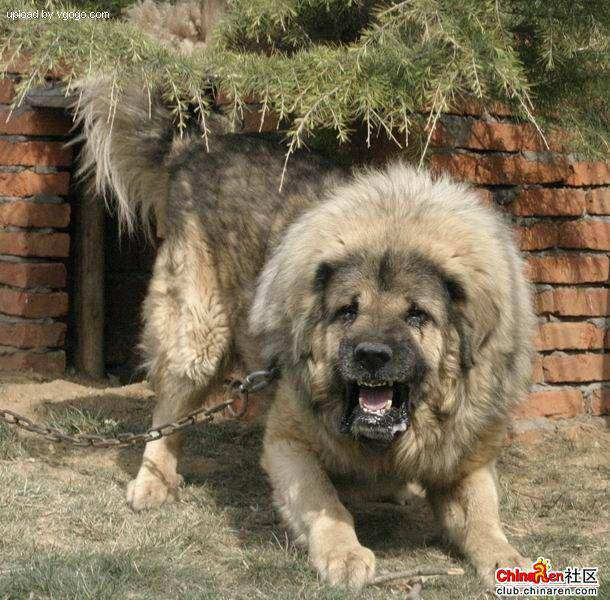

In [71]:
Image(filenames[9000])

In [72]:
labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels) same as above
labels[:10], len(labels)

(array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
        'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
        'scottish_deerhound'], dtype=object),
 10222)

In [73]:
# Check if the number of labels match the number of filenames
if len(labels) == len(filenames):
  print('Labels match the actual amount of files, Proceed!')
else:
  print('Labels does no tmatch the actual amount of file, check the target directory')

Labels match the actual amount of files, Proceed!


In [74]:
# Find unique label values
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds) # That must return a length of 120.

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

In [75]:
# Turn a single label into an array of boolean
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [76]:
# Turn every label into an array of boolean
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [77]:
# Example : turning boolean array into integers
print(labels[0]) # print the original label
print(np.where(unique_breeds == labels[0])) # the index where label occurs
print(boolean_labels[0].argmax())  # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # That will return a 1 where the label occurs in the boolean array

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from kaggle does not come with a validation set, we will create our own

In [78]:
# Setup X and y variables
X = filenames
y = boolean_labels

We are going to experimenting ~ 1000 images and increase as needed

In [79]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:'slider', min:1000, max:10000, step:1000}
# This is a magic function

In [80]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Set a random seed
np.random.seed(42)

# Split them into train and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [81]:
# Have a look to the training data
X_train[:5], y_train[:5]

(['drive/MyDrive/Dogbreed_Identification/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dogbreed_Identification/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dogbreed_Identification/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dogbreed_Identification/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dogbreed_Identification/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, 

## Preprocessing Images(Turning images into tensors)
To preprocess our images into tensors we are going to write a function that does:
- Take an image file path as an input.
- Use TensorFlow to read the image and save it to a file called `image`.
- Turn out `image` into tensors.
- Normalize our `image`(Convert the colour channel values from 0-255 to 0-1).
- Resize the image to be a size of(224, 224).
- Return the modified `image`.

### Before we do, let's see what importing an image looks like

In [82]:
filenames[42]

'drive/MyDrive/Dogbreed_Identification/train/011e06760794850c40f23d6426c40774.jpg'

In [83]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]], dtype=uint8)
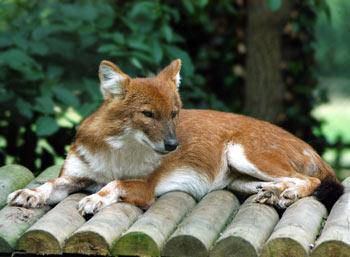

In [84]:
# Our image is stored now as a numpy array, tensors are like an np array
image

In [85]:
image.max(), image.min() # pixels that hold color code from 0 to 255

(255, 0)

In [86]:
# Turning the image into tensors, display first 2 items
tf.constant(image)[:2]
# The difference between these tensors and the last np array, is that tensors are able to run on GPU, so much faster for computing

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

Now we have seen what an image looks like as a tensor, now let's make a function to preprocess them.

* Take an image file path as an input.
* Use TensorFlow to read the image and save it to a file called image.
* Turn out image into tensors.
* Convert the colour channel values from 0-255 to 0-1.
* Resize the image to be a size of(224, 224).
* Return the modified image.

In [87]:
# Define images size
IMG_SIZE = 224
# Create a function for preprocessing images
def process_images(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turn the image into tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg images into numerical tensors with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Turn the colour channel values from 0-255 to 0-1, this process is called normalization
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired values
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [88]:
# Demo of the above function
(process_images(X[42]), tf.constant(y[42]))
# We have obtained a tuple of tensors (image, label)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

## Turning our data into batches

Why turn data into batches?

Let's say you are trying to process 10,000+ images in one go...They all might not fit into memory.(limited GPU)!

So that's what we do about 32 (batch size) images at a time( you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of tensor tuples which looks like this : `(image, label)`


In [89]:
# Create a simple function return a tuple of (image, label)
def get_image_label(image_path, label):
  """Take an image file path name and the associated label
  processes the image and return a tuple of (image, label) """
  image = process_images(image_path)
  return image, label

In [90]:
# Demo of the above function
get_image_label(X[10], y[10])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.41753423, 0.38224012, 0.40184796],
         [0.4316044 , 0.39631027, 0.4159181 ],
         [0.40602714, 0.37879497, 0.3957155 ],
         ...,
         [0.19028023, 0.17067239, 0.18635866],
         [0.28062278, 0.26101494, 0.2767012 ],
         [0.28965282, 0.27004498, 0.28573126]],
 
        [[0.36733648, 0.33204237, 0.3516502 ],
         [0.3150591 , 0.27976498, 0.29937282],
         [0.29561085, 0.26837867, 0.2852992 ],
         ...,
         [0.23583163, 0.21230222, 0.22014536],
         [0.2812507 , 0.25772128, 0.2655644 ],
         [0.26320195, 0.23967254, 0.24751568]],
 
        [[0.40703085, 0.3717367 , 0.3907143 ],
         [0.46396694, 0.42867282, 0.4476504 ],
         [0.5020599 , 0.47482777, 0.491118  ],
         ...,
         [0.27574417, 0.24076518, 0.24374136],
         [0.30945447, 0.27447549, 0.27745166],
         [0.25501153, 0.22003253, 0.22300872]],
 
        ...,
 
        [[0.26359692, 0.28712633

Now we have got a way to turn our data into tuples of tensors in the form `(image, label)`. Now let's make a function to turn all of our data(X, y) into batches of size 32.

In [91]:
# Define the batch size, 32 is a good size to start with
BATCH_SIZE = 32
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles data if it is a training data and doesn't shuffle if it is validation data.
  Also accepts test data as an input (without labels).
  """
  # if the data it's a test dataset, we probably don't have labels
  if test_data:
    print('Creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only pathfiles no labels
    data_batch = data.map(process_images).batch(BATCH_SIZE)
    return data_batch

  # if the data is valid dataset, we don't need to shuffle it
  elif valid_data:
    print('Creating validation data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print('Creating training data batches...')

    # Turn filepaths and labels into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling pathnames and labels before mapping image processor function much faster than shuffling images
    data = data.shuffle(buffer_size=len(X))  # buffer_size stand for how manyu variables do I want to shuffle

    # Create (image, label) tuple, this also turns image path into preprocessed image
    data = data.map(get_image_label)

    # Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [92]:
# Create our training and validation data batches
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [93]:
# Check out the different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them.

In [94]:
import matplotlib.pyplot as plt

# Create a function for viewing images in data batches
def show_25_images(images, label):
  """
  Displays a plot of 25 images and their labels from a data batches
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25(for dispalying 25 images)
  for i in range(25):
    # Create subplots(5rows, 5columns)
    ax = plt.subplot(5, 5, i+1)
    # plot an image
    plt.imshow(images[i])
    # Add the image label to the title
    plt.title(unique_breeds[label[i].argmax()])
    plt.axis('off')

In [95]:
train_data, valid_data

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>)

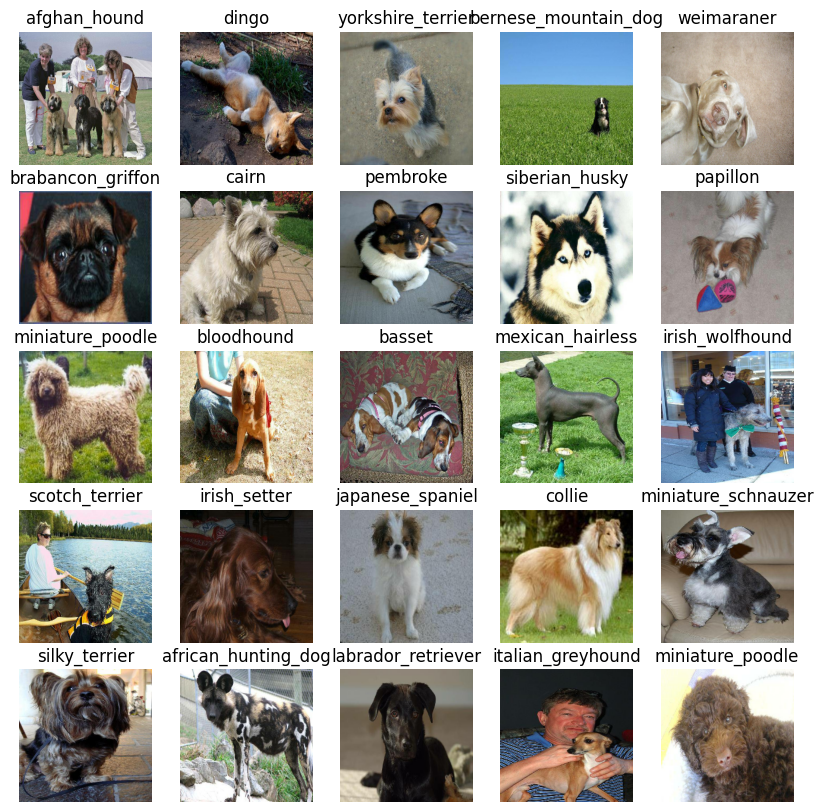

In [96]:
# We need to convert our train data from batches to iterator in order to visualize it
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

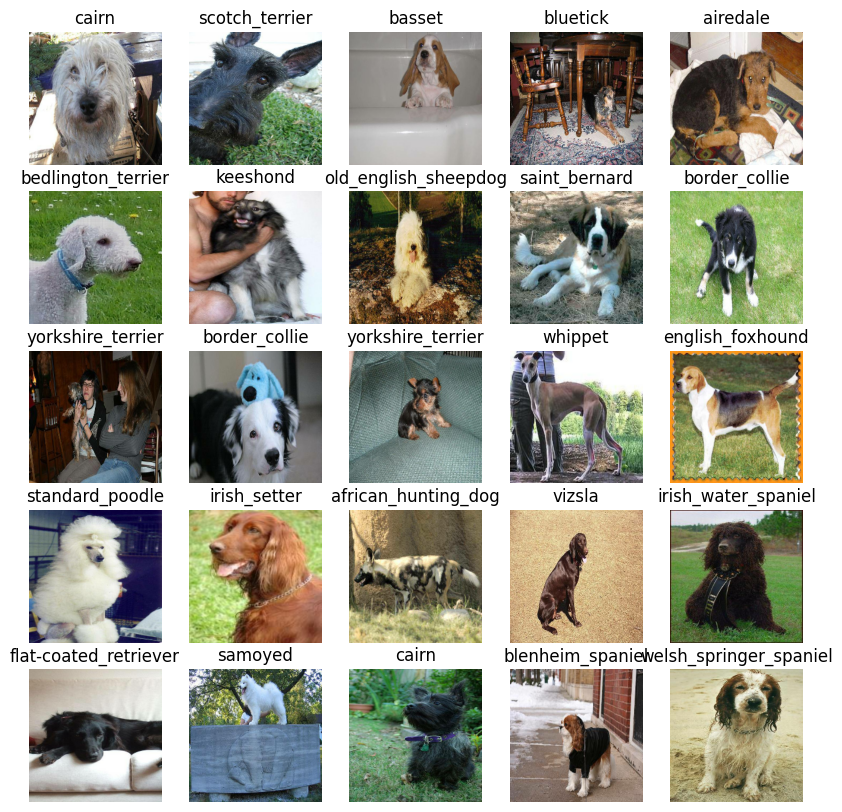

In [97]:
# Now let's visualize our validation set
val_images, val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build the model, there are few things we need to define :
- The input shape(images shape, in the form of tensors) to our model.
- The ouput shape(image label, in the form of tensors) to our model.
- The URL of the model we want to use from tensor flow hub.

In [1]:
# Set up the input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # [batch, width, height, channel_colors]

# Set up output shape
OUTPUT_SHAPE = len(unique_breeds)

# Set up model URL from TensorFlow Hub
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5'

NameError: name 'IMG_SIZE' is not defined

Now we've got our inputs outputs and model ready to go.
Let's put them together into a keras deep learning model!

knowing this, let's create a function which:
* Takes the input shape, the output shape and the model that we've chosen as parameters.
* Defines the layers in a keras model in a sequential fashion(do this, then this, then that).
* Compiles the model(syas it should be evaluated and improved).
* Builds the model(Tells the model the input shape it will be getting).
* Returns the model.

In [99]:
# Create a function which builds a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print('Builduing the model with:', MODEL_URL)

  # Set up the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # layer1 : input layer
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                           activation='softmax') # layer2 : output layer
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'])

# Build the model
  model.build(INPUT_SHAPE)

  return model

In [100]:
model = create_model()
model.summary()

Builduing the model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x7832386d69e0> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

## Creating CallBacks
Callbacks are helper functions a model can use during training to do such things, as to save its progress, to ckeck progress or to stop training early if a model stop improving.

We will create two callbacks, one for tensorBoard which helps track our mode progress, and another one for early stopping which prevents our model from training for too long.

## TensorBoard CallBack

To set up a tensorboard callback we need perform three steps:

1. Load the tensorboard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs using the `%tensorboard` magic function(we will do this after model training).

In [ ]:
# Load tensorboard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing tensorboard logs
  logdir = os.path.join('drive/MyDrive/Dogbreed_Identification/logs',
                         # Make it so the logs get tracked whenever we run the experiment
                         datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  return tf.keras.callbacks.TensorBoard(logdir)

### Generalization

Is the ability for a machine learning model to perform well on data it hasn't seen before.

## Early stopping callback

Early stopping helps stop our model from overfitting by stopping trainning if a certain evaluation metric stops improvement.



In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                  patience=3)

## training a model(on subset of data)

Our first model is only going to train on 1000 images, to make sure that everything is working.

In [ ]:
# Set the epochs number
NUM_EPOCHS = 100 # @param {type : 'slider', min : 10, max : 100, step : 10}

In [ ]:
# Check to make sure we are still working on GPU, otherwise, the process will take a huge amount of time and memory
print('GPU', 'Available YESSS!! :)' if tf.config.list_physical_devices('GPU') else 'Not Available :(')

Let's create a function which trains a model

* Create a model using `create_model()`.
* Create TensorBoard callback using `create_tensorboard_callback()`.
* Call the fit function on our model, passing it the train data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we want to use.
* Return the model.


In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version
  """
  # Create a model
  model = create_model()

  # Create TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data and passing it to the callbacks we created
  model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data=valid_data,
             validation_freq=1,
             callbacks=[tensorboard, early_stopping])

  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

**Question:** It looks like our model is overfitting becuase it performing far better on the training dataset than on the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?

**Note: Overfitting is good to begin with, it means that our model is learning!**

*The central challenge in machine learning is that we must perform well on new, previously unseen inputs — not just those on which our model was trained. The ability to perform well on previously unobserved inputs is called generalization.*

## Checking the TensorBoard Logs

The TensorBoard magic function `%tensorboard`, will access the logs directory we have created earlier and visualize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Dogbreed_Identification/logs

## Make and evaluate predictions with the trained model

In [ ]:
valid_data

In [ ]:
# Make predictions on the validation data(not used to train on)
predictions = model.predict(valid_data, verbose=1)
predictions

The result of our predictions are associated probabilities for likeliness(likelihood), what our model thinks a ceratin image is(by propable label), so the sum of these probabilities should be approximately 1.

Since we have used `softmax` function as an activation we have obtained labels as values between (0, 1) see more about `softmax` function in the link below.
https://fr.wikipedia.org/wiki/Fonction_softmax

In [ ]:
np.sum(predictions[0])

In [ ]:
len(predictions[0])
# That's the same length of our labels, which means that each probability is assciated to likelihood label.

In [ ]:
# First prediction
index=0
print(f'Max value(predicted label):{np.max(predictions[index])}')
print(f'Sum:{np.sum(predictions[index])}')
print(f'Index of the Max:{np.argmax(predictions[index])}')
print(f'Predicted Label:{unique_breeds[np.argmax(predictions[index])]}')

Having the above functionality is great but we want to be able to do it at a scale.

Also it would be even better if we can visualize the image the prediction is made on.

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# turn prediction probabilities into their respective labels
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probailities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
get_pred_label(predictions[15])

Now since our validation data is still in batch dataset, we have to unbatchify it in order to make predictions on the validation images and then compare it to the validation labels.

In [ ]:
# What we should do in order to get our validation images and labels
# New list names to differentiate previous creations
images_=[]
labels_=[]
# Loop through unbatched data
for image, label in valid_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

images_[0], labels_[0]

#### The above code should be functionalized for more reliability.

In [ ]:
# Create function to unbacthify a batch dataset
def unbatchify(data):
  """
  Take a batched dataset of (image, label) tensors, unbatchify it and return separete arrays of images and labels.
  """
  images, labels = [], []
  for image, label in data.unbatch().as_numpy_iterator():

    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Test: Unbatchify validation dataset and return separate arrays of images, labels
valid_images, valid_labels = unbatchify(valid_data)
valid_images[0], valid_labels[0]

Now we have got :
* Prediction labels.
* Validation images.
* Validation labels (True labels).

Let's make these more visual by creating some function.

We will create a function that:

* Takes an array of predicted probabilities, an array of truth labels and an integer.
* Convert the predicted probabilities to a predicted label.
* Plot the predicted probability its predicted label, the truth label and the target image on a single plot.


In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth, image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Set up plot, plot image and remove ticks
  plt.figure(figsize=(8, 6))
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the title color depending on if the predicted label is true or wrong
  if pred_label == true_label:
    color = 'green'
  else:
    color = 'red'

  # Change the plot title to be, predicted label, prediction probability and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label, (np.max(pred_prob)*100), true_label), color=color)

In [ ]:
# Test our above function
plot_pred(prediction_probabilities=predictions,
          labels=valid_labels,
          images=valid_images, n=99)

Now whave got a function to visualize our model top predictions, now let's crearte a plot in order to visualize model's top 10 predictions.

This function will:

* Take an input of probability prediction array and a ground truth array and an integer.
* Find the prediction using `get_pred_label()`.
* Find the top 10:

 - Prediction probabilities values.
 - Prediction probabilities indexes.
 - Prediction labels.

 * Plot the top 10 predictions probability and labels, with green color for true predictions.




In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest predictions confidences along with truth label for sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidences indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidences values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Set up plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color='grey')
  plt.xticks(np.arange(len(top_10_pred_labels)),
              labels=top_10_pred_labels, rotation='vertical')

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

In [ ]:
plot_pred_conf(prediction_probabilities=predictions, labels=valid_labels, n=99)

Now we have got some function to help us visualize our predictions and evaluate our model. Now let's check out a few.

In [ ]:
# Let's check out a few predictions and their different values
# These few lines of code will be a combination of the two last visualization functions
i_multiplier=10
num_rows=3
num_cols=2
num_images=num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=valid_labels,
            images=valid_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions, labels=valid_labels, n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show();

**Challenge:** How would you create a confusion matrix between predictions and true labels??

## Saving & Reloading a trained model

In [ ]:
# Create a function to save model
def save_model(model, suffix=None):
  """
  Saves a given trained model in a models directory and append a suffix(str)
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join('drive/MyDrive/Dogbreed_Identification/models',
                            datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  model_path = modeldir + '-' + suffix + 'h5'
  print(f'Saving model to:{model_path}...')
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a trained model from a specified path
  """
  print(f'Loading a saved model from:{model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={'KerasLayer':hub.KerasLayer})
  return model

Now we have got functions to save and load a trained model, let's make sure they working well.

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix='1000-images-mobilenetv2-Adam')

In [ ]:
# Load the model
loaded_1000_image_model = load_model('drive/MyDrive/Dogbreed_Identification/models/20210924-16041632499457-1000-images-mobilenetv2-Adamh5')

In [ ]:
# Evaluate the saved model
model.evaluate(valid_data)

In [ ]:
# Evaluate the loaded model, that shoulde return same results if everything working well
loaded_1000_image_model.evaluate(valid_data)


## Training a big model(on the full data).

let's train our model on the full data set(X, y).

In [ ]:
len(X), len(y)

In [ ]:
# Create full data batches
full_data = create_data_batches(X, y)

In [ ]:
full_data

In [ ]:
# Create a model for training full data
full_model = create_model()

In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                              patience=3)

Running the cell below will take a little while(maybe up to 1 hour or more for the first epoch), because the GPU we are using in the runtime has to load all of our 10,000+ images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x=full_data,
              epochs=NUM_EPOCHS,
              callbacks=[full_model_tensorboard, full_model_early_stopping])

In [ ]:
save_model(full_model, suffix='full_image_set_mobilenetv2-Adam')

In [ ]:
# Load in the full model
loaded_full_model = load_model('drive/MyDrive/Dogbreed_Identification/models/20211005-06371633415827-full_image_set_mobilenetv2-Adamh5')

## Making predictions on test dataset

Since our model has been trained on images in the form of tensor batches, to make predictions on the test data, we will have to get it in the same format.

Luckily we have created our function `create_data_batches()` earlier which can take a list of filenames as input and convert them into tensor batches.

To make predictions on the test data, we will :
* Get the test images filenames.
* Convert filenames into test data batches using `create_data_batches()` and setting the test data parameter to `True`, since the test data doesn't have labels.
* Make predictions array by passing the test data batches to the `predict()` method called on our model.

In [ ]:
# Load test images filenames
test_path = 'drive/MyDrive/Dogbreed_Identification/test/'
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:5]

In [ ]:
len(test_filenames)

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

In [ ]:
test_data

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run(about 1hour or more).

In [ ]:

# Make predictions on test data batches using the loaded_full_model
#test_prediction = loaded_full_model.predict(test_data, verbose=1)

In [ ]:
# Save predictions (NUmpyArray) to csv file (for access later)
#np.savetxt('drive/MyDrive/Dogbreed_Identification/preds_array.csv', test_predictions, delimiter=',')

### Because of the error we have got in the predictions step below, I have downloaded the predictions array from the course results section to continue the project, and come back later to handle this ambiguous error!!

In [ ]:
# Load predictions (numpyarray) from csv file
test_predictions = np.loadtxt('drive/MyDrive/Dogbreed_Identification/dog-vision-prediction-probabilites-array.csv', delimiter=',')
test_predictions[:10]

In [ ]:
test_predictions.shape

In [ ]:
len(test_filenames)

## Preparing test dataset predictions for Kaggle

Looking at the kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dogbreed. Read more information on the link below.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format we will:

* Create a pandas DataFrame with an ID column as well as a column for each dogbreed.
* Add data to ID columln by extarcting the test image ID's from their filepaths.
* Add data(the prediction probabilities) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
len(list(unique_breeds))

In [ ]:
# Creates a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=['id']+list(unique_breeds))
preds_df

In [ ]:
# Append test image ID to predcitions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
# Assign df_preds[id] to test_ids
preds_df['id'] = test_ids
preds_df.head()

In [ ]:
preds_df.shape, test_predictions.shape

In [ ]:
# Append each of dogbreed columns with its prediction probability from the test predictions array
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

In [ ]:
#@title Settings
#@markdown Rerun this cell if you change settings
normed_vectors = True #@param {type: "boolean"}
metric = "cosine similarity" #@param ["euclidean norm", "cosine similarity"] {type:"string"}

cosine = False
if metric is "cosine similarity":
  cosine = True
import emath
data, emojis = emath.get_data(normed=normed_vectors)

In [ ]:
# Emojis
!pip install emath@git+git://github.com/whitead/emoji-math.git

In [ ]:
import calendar

print(calendar.month(2022, 1))

In [ ]:

# Create data
y = 200 + np.random.randn(100)
x = [i for i in range(len(y))]

# Plot data
plt.subplots(figsize=(10, 6))
sns.lineplot(x=x, y=y)
plt.fill_between(x, y, 195, where=(y>195), facecolor='lightblue')
plt.title('Sample Visualization'.title(), fontsize=14, weight='bold');

function ConnectButton(){
    console.log("Working");
    document.querySelector("#connect​").click()
}

setInterval(ConnectButton,60000);

# Nouvelle section